# Problem statement

> Should Olist remove underperforming sellers from its marketplace?

<details>
    <summary>Hints</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate your source code in `seller.py` - how was the mean `review_score` per seller computed? Can you imagine a way to amend your code  to compute `cost_of_reviews` in the same process? 
</details>


## Import

In [1]:
%load_ext autoreload
%autoreload 2

from olist.data import Olist
from olist.order import Order
from olist.seller import Seller

from matplotlib.lines import Line2D

import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(context='talk', style='whitegrid', palette='Set1')

## Load Data

In [2]:
sellers = Seller().get_training_data()

In [3]:
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,it_costs,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,72.688090,129.181910
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,265.419379,1784.887621
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,41.966489,-26.166489
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,41.966489,-33.967489
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,41.966489,-125.167489


## Profits

### Profits per sellers

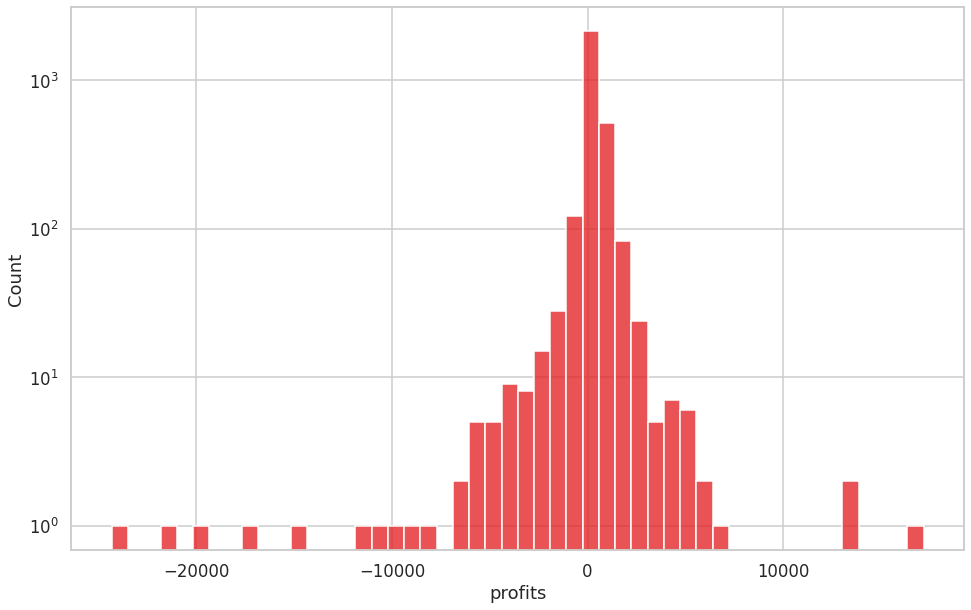

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sns.histplot(sellers["profits"], bins=50, log_scale=(False, True), ax=ax);

### Optimal number of bad sellers to remove

In [5]:
new_profit = []
new_it_costs = []
new_cost_of_reviews = []
new_revenues = []

nb_sellers_to_remove = 2000
for i in range(nb_sellers_to_remove):
    X = sellers.sort_values(by="profits", ascending=True).iloc[i:, :].copy()
    new_profit.append(X['profits'].sum())
    new_it_costs.append(X['it_costs'].sum())
    new_cost_of_reviews.append(X['cost_of_reviews'].sum())
    new_revenues.append(X['revenues'].sum())

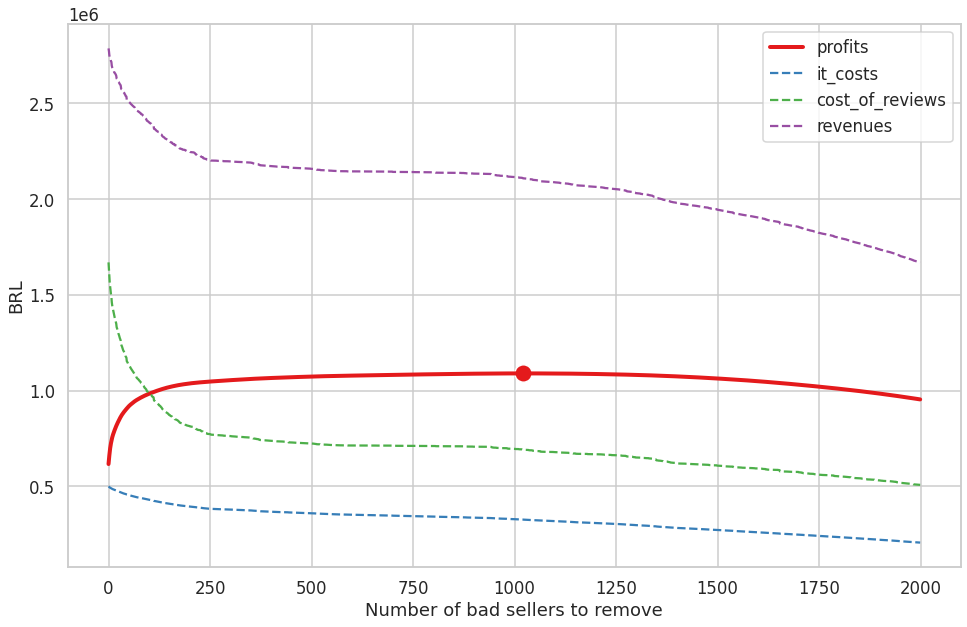

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sns.lineplot(x=range(nb_sellers_to_remove), y=new_profit, ax=ax, label="profits", linewidth=4)
sns.lineplot(x=range(nb_sellers_to_remove), y=new_it_costs, ax=ax, label="it_costs", linestyle="--")
sns.lineplot(x=range(nb_sellers_to_remove), y=new_cost_of_reviews, ax=ax, label="cost_of_reviews", linestyle="--")
sns.lineplot(x=range(nb_sellers_to_remove), y=new_revenues, ax=ax, label="revenues", linestyle="--")

sns.scatterplot(x=[np.argmax(new_profit)], y=[np.max(new_profit)], ax=ax, s=300)
# ax.axvline([np.argmax(new_profit)],color="black",linestyle="--")
ax.set_xlabel("Number of bad sellers to remove")
ax.set_ylabel("BRL");

In [7]:
print(f"Number of bad sellers to remove: {np.argmax(new_profit)}")
print(f"New profit: {int(np.round(np.max(new_profit)))} BRL")
print(f"Gain:  {int(np.round(np.max(new_profit) - new_profit[0]))} BRL ({int(np.round((np.max(new_profit) - new_profit[0]) / new_profit[0] * 100))}%)")

Number of bad sellers to remove: 1022
New profit: 1090027 BRL
Gain:  473062 BRL (77%)


## Bad sellers detection

### Add seller_type column

In [8]:
sellers["seller_type"] = "Good"
sellers.sort_values(by="profits", ascending=True, inplace=True)
sellers.loc[sellers.index[:np.argmax(new_profit)], "seller_type"] = "Bad"

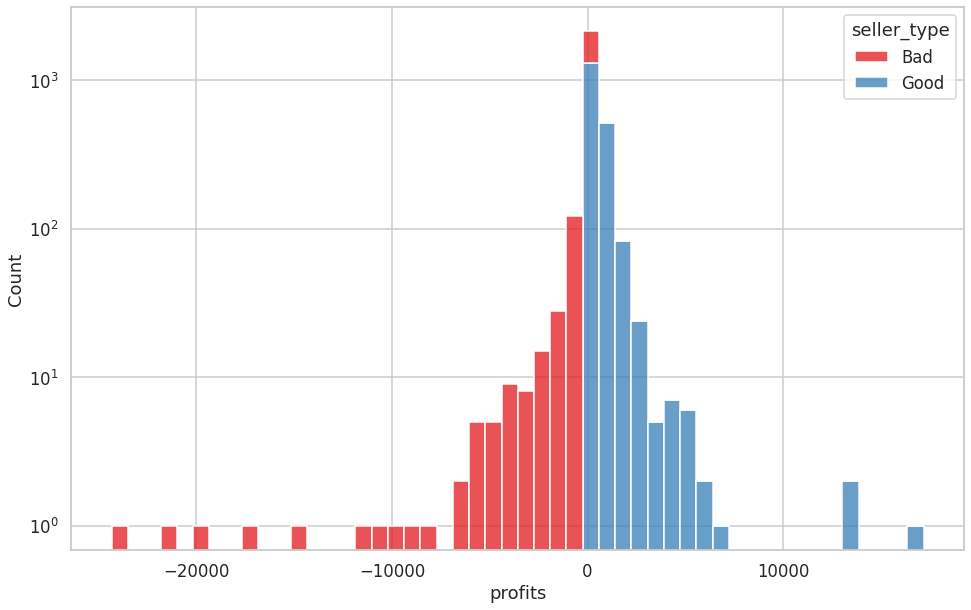

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sns.histplot(x='profits', data=sellers, bins=50, hue="seller_type", log_scale=(False, True), ax=ax, multiple="stack");

### Cumulative profits per seller per week

#### Data preparation

In [10]:
# Data preparation
data = Olist().get_data()

df_orders_item = data["order_items"].groupby(by=["order_id", "seller_id"]).agg({"price": sum}).reset_index()
df = data["orders"].merge(df_orders_item, on="order_id").merge(data["order_reviews"], on="order_id")
df = df[["seller_id", "order_id", "order_purchase_timestamp", "price", "review_score"]]
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

#### Compute cumulative profits

In [14]:
def compute_cumulative_profits(df, sellers):

    seller_ids = sellers["seller_id"]
    cumulative_data = {}

    for seller_id in seller_ids:
        # for each seller
        df_tmp = df.loc[df.seller_id == seller_id, :].copy()
        df_tmp.sort_values(by="order_purchase_timestamp", inplace=True)

        # Compute cost of reviews
        df_tmp["cost_of_reviews"] = df_tmp["review_score"].map({
            1: 100,
            2: 50,
            3: 40,
            4: 0,
            5: 0
        })

        # Aggregate per week
        df_tmp = df_tmp.groupby(pd.Grouper(key='order_purchase_timestamp', freq='W-MON')).agg(
            {"price": sum, "cost_of_reviews": sum, "order_id": 'count'})

        # Compute cumulative revenues
        df_tmp["cumsum_revenues"] = df_tmp["price"].cumsum() * .1 + np.maximum(np.ceil((df_tmp.index - df_tmp.index[0]) / np.timedelta64(1, 'M')), 1)*80

        # Compute cumulative cost of reviews
        df_tmp["cumsum_cost_of_reviews"] = df_tmp["cost_of_reviews"].cumsum()

        # Compute cumulative IT costs
        df_tmp["cumsum_n_orders"] = df_tmp["order_id"].cumsum()
        it_cost = sellers[sellers.seller_id == seller_id].it_costs
        df_tmp["cumsum_it_costs"] = df_tmp["cumsum_n_orders"].apply(lambda x: it_cost / np.sqrt(df_tmp["cumsum_n_orders"][-1]) * np.sqrt(x))

        # Compute cumulative profits
        df_tmp["cumsum_profits"] = df_tmp["cumsum_revenues"] - df_tmp["cumsum_cost_of_reviews"] - df_tmp["cumsum_it_costs"]

        # reset index
        df_tmp.reset_index(inplace=True)

        # Save cumulative data
        cumulative_data[seller_id] = df_tmp[["cumsum_profits", "cumsum_revenues", "cumsum_cost_of_reviews", "cumsum_it_costs"]]

    return cumulative_data

In [15]:
cumulative_data = compute_cumulative_profits(df, sellers)

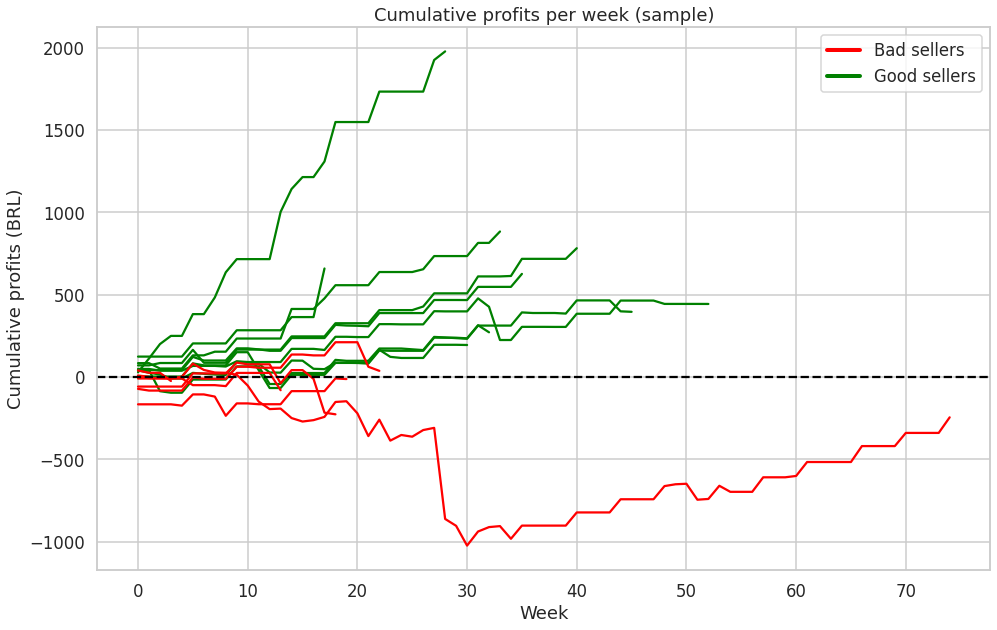

In [26]:
n_samples = 10

good_seller_ids_sample = sellers.loc[sellers.seller_type == "Good", "seller_id"].sample(n_samples, random_state=55)
bad_seller_ids_sample = sellers.loc[sellers.seller_type == "Bad", "seller_id"].sample(n_samples, random_state=55)
seller_ids_sample = good_seller_ids_sample.append(bad_seller_ids_sample)

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
for i in seller_ids_sample:
    if sellers.loc[sellers.seller_id == i].seller_type.values[0] == "Good":
        sns.lineplot(x=cumulative_data[i].index, y="cumsum_profits", data=cumulative_data[i], color="green", ax=ax)
    if sellers.loc[sellers.seller_id == i].seller_type.values[0] == "Bad":
        sns.lineplot(x=cumulative_data[i].index, y="cumsum_profits", data=cumulative_data[i], color="red", ax=ax)

ax.axhline(0, ls='--', color="black")
ax.set_title("Cumulative profits per week (sample)")
ax.set_ylabel("Cumulative profits (BRL)")
ax.set_xlabel("Week")

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4)]
ax.legend(custom_lines, ['Bad sellers', 'Good sellers']);

### Find a week threshold after which sellers must have a positive profit

In [27]:
week_threshold = range(1, 80)
gain_per_threshold = []

for w in week_threshold:
    balance = []
    for i in sellers["seller_id"]:
        if cumulative_data[i].loc[min(w, cumulative_data[i].shape[0]-1), "cumsum_profits"] < 0:
            balance.append(cumulative_data[i]["cumsum_profits"].iloc[-1]-cumulative_data[i].loc[min(w, cumulative_data[i].shape[0]-1), "cumsum_profits"])
    gain_per_threshold.append(-1*np.sum(balance))

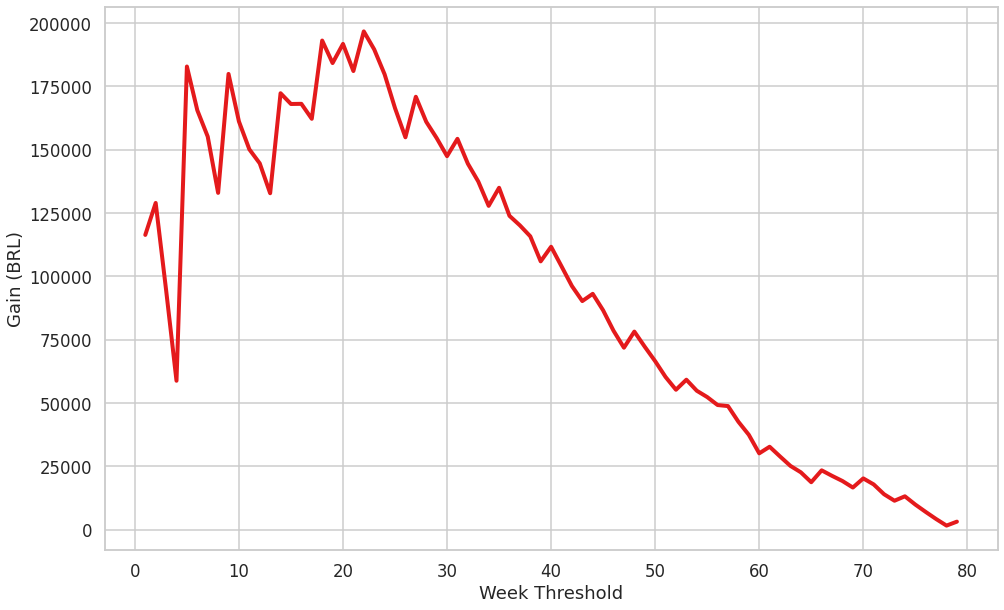

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sns.lineplot(x=week_threshold, y=gain_per_threshold, ax=ax, linewidth=4)
ax.set_xlabel("Week Threshold")
ax.set_ylabel("Gain (BRL)");

In [29]:
best_threshold = np.argmax(gain_per_threshold) + 1
print(f"Best week threshold: {best_threshold} weeks, giving us an effective gain of {int(np.round(np.max(gain_per_threshold)))} BRL")

Best week threshold: 22 weeks, giving us an effective gain of 196699 BRL


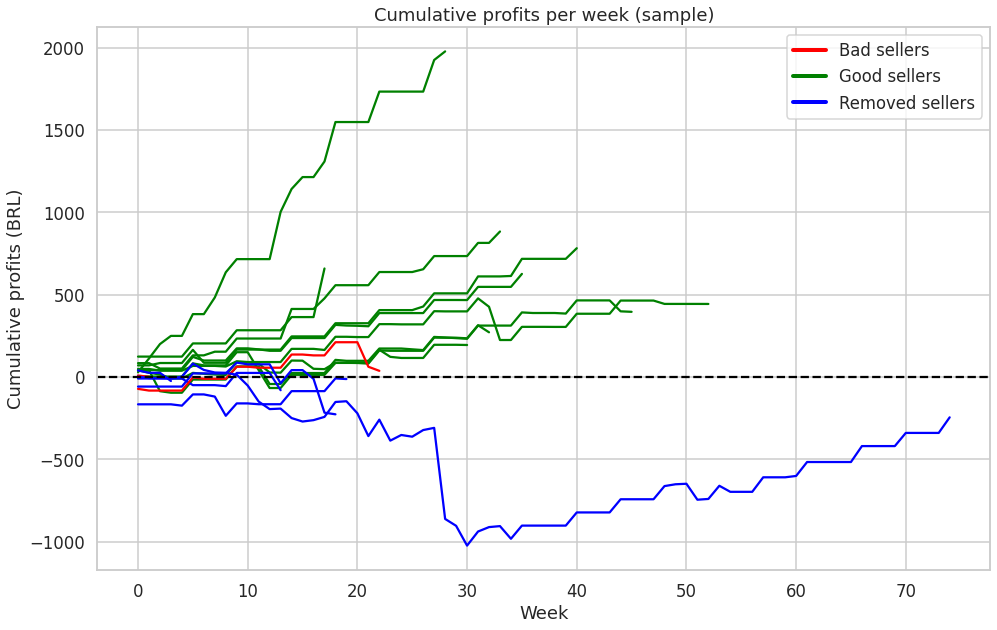

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
for i in seller_ids_sample:
    if cumulative_data[i].loc[min(best_threshold, cumulative_data[i].shape[0]-1), "cumsum_profits"] > 0:
        if sellers.loc[sellers.seller_id == i].seller_type.values[0] == "Good":
            sns.lineplot(x=cumulative_data[i].index, y="cumsum_profits", data=cumulative_data[i], color="green")
        if sellers.loc[sellers.seller_id == i].seller_type.values[0] == "Bad":
            sns.lineplot(x=cumulative_data[i].index, y="cumsum_profits", data=cumulative_data[i], color="red")
    else:
        sns.lineplot(x=cumulative_data[i].index, y="cumsum_profits", data=cumulative_data[i], color="blue")
        balance.append(cumulative_data[i]["cumsum_profits"].iloc[-1]-cumulative_data[i].loc[min(best_threshold, cumulative_data[i].shape[0]-1), "cumsum_profits"])

ax.axhline(0, ls='--', color="black")
ax.set_title("Cumulative profits per week (sample)")
ax.set_ylabel("Cumulative profits (BRL)")
ax.set_xlabel("Week")

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="blue", lw=4)]
ax.legend(custom_lines, ['Bad sellers', 'Good sellers', 'Removed sellers']);